In [10]:
import os
import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
from model_creator import LSTMModel, ELECTRODES

In [11]:
SEGMENT_LENGTH = 50  # Input length in seconds
PREDICTION_LENGTH = 5  # Prediction length in seconds
SAMPLING_RATE = 500  # EEG sampling rate (Hz)
WINDOW_SIZE = SEGMENT_LENGTH * SAMPLING_RATE  # Total input size
PREDICT_SIZE = PREDICTION_LENGTH * SAMPLING_RATE  # Total output size
OVERLAP = 0.5  # Overlap between windows
EPOCHS = 20  # Number of epochs
LAYER1 = 128  # Number of neurons in the first LSTM layer
LAYER2 = 64  # Number of neurons in the second LSTM layer
BATCH_SIZE = 32

In [12]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Prepare The Data

In [13]:
def load_and_preprocess_data(start_idx, end_idx):
    print(f"Loading data for patients {start_idx-1000}-{end_idx-1000}...")
    path = [f"C:\\Users\\orben\\Downloads\\Data for ML project\\sub-{str(i)[1:]}\\eeg\\sub-{str(i)[1:]}_task-eyesclosed_eeg.set" for i in range(start_idx, end_idx + 1)]
    
    eeg_data = []
    for file_path in tqdm(path):
        # Load the EEG data
        raw = mne.io.read_raw_eeglab(file_path, preload=True)
        # Select only frontal electrodes
        data = raw.get_data(picks=ELECTRODES)
        eeg_data.append(data)
    
    return eeg_data

def segment_data(data, window_size, predict_size, overlap=0.5):
    inputs = []
    labels = []

    for recording in data:
        # Initialize scaler for each recording
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # Reshape to (time_points, channels) for scaling
        recording_reshaped = recording.T
        
        # Scale the data
        normalized = scaler.fit_transform(recording_reshaped)
        
        # Segment the data into overlapping windows
        for start in range(0, normalized.shape[0] - window_size - predict_size, int(window_size * (1 - overlap))):
            # Extract segments for all channels
            input_segment = normalized[start:start + window_size, :]
            label_segment = normalized[start + window_size:start + window_size + predict_size, :]
            inputs.append(input_segment)
            labels.append(label_segment)

    return np.array(inputs), np.array(labels)

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
# Define patient groups
PATIENT_GROUPS = {
    'AD': (1, 36),      # Alzheimer's Disease patients
    'Healthy': (37, 65), # Healthy patients
    'FTD': (66, 88)     # Frontotemporal Dementia patients
}
# Select which group to test on
TRAIN_GROUP = 'Healthy'  # Change this to train on different groups
TEST_GROUP = 'Healthy'  # Change this to test on different groups
first, last = PATIENT_GROUPS[TEST_GROUP]
first_trained, last_trained = PATIENT_GROUPS[TRAIN_GROUP]

In [15]:
print(f"\nTesting model trained on {TRAIN_GROUP} on {TEST_GROUP} patients (indices {first}-{last})...")

# Load test data
eeg_data = load_and_preprocess_data(1000 + first, 1000 + last)
inputs, labels = segment_data(eeg_data, WINDOW_SIZE, PREDICT_SIZE, OVERLAP)

# Create dataset and dataloader
test_dataset = EEGDataset(inputs, labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Test data shape - Inputs: {inputs.shape}, Labels: {labels.shape}")


Testing model trained on Healthy on Healthy patients (indices 37-65)...
Loading data for patients 37-65...


100%|██████████| 29/29 [00:04<00:00,  6.23it/s]


Test data shape - Inputs: (930, 25000, 6), Labels: (930, 2500, 6)


# Load & Train The Model

In [16]:
# Load the trained model
model = LSTMModel(input_size=len(ELECTRODES), hidden_size1=LAYER1, hidden_size2=LAYER2, output_size=PREDICT_SIZE)
model_path = f'Models/{SEGMENT_LENGTH}-{PREDICTION_LENGTH}_{TRAIN_GROUP}_patients_model({LAYER1},{LAYER2}){EPOCHS}epochsOverlap{OVERLAP}frontal-electrodes.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

LSTMModel(
  (lstm1): LSTM(6, 128, batch_first=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(128, 64, batch_first=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=15000, bias=True)
  (relu): ReLU()
)

In [17]:
# Generate predictions
print(f"\nTesting the model...")
y_pred = []
y_true = []

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(tqdm(test_loader, desc="Processing batches")):
        # Optional: Clear GPU cache periodically
        if device.type == 'cuda' and batch_idx % 10 == 0:
            torch.cuda.empty_cache()
        
        # Move to device and process
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        # Move back to CPU and convert to numpy
        batch_pred = outputs.cpu().numpy()
        batch_true = labels.numpy()
        
        # Store results
        y_pred.append(batch_pred)
        y_true.append(batch_true)
        


# Combine all batches
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

print("Prediction generation complete!")


Testing the model...


Processing batches: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]

Prediction generation complete!


## Plot Prediction

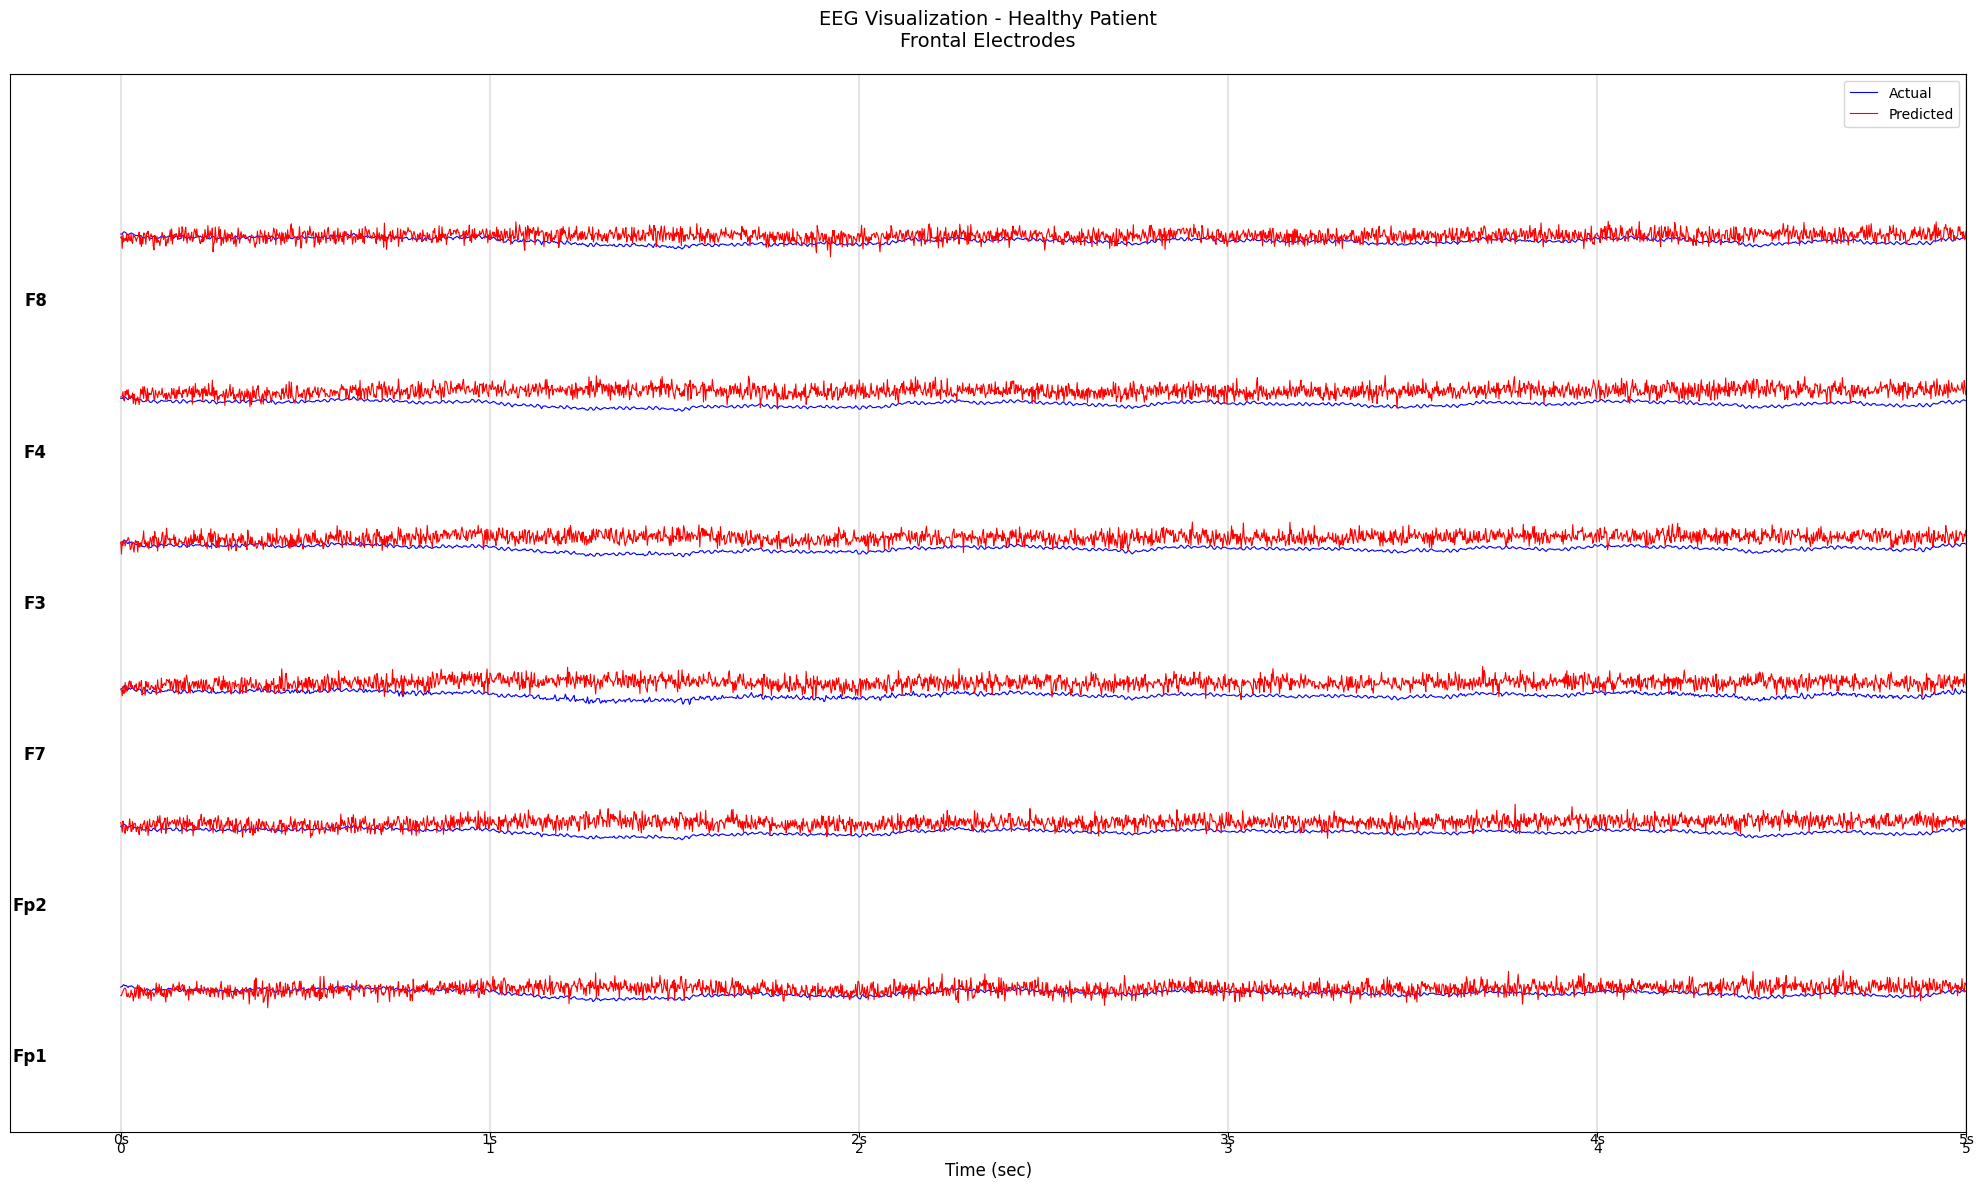

In [18]:
# Create figure
plt.figure(figsize=(20, 12))

# Generate time axis for the prediction length
time_axis = np.linspace(0, PREDICTION_LENGTH, PREDICT_SIZE)

# Define electrode order and spacing
spacing = 0.15  # Vertical spacing between signals
electrode_order = ['F8', 'F4', 'F3', 'F7', 'Fp2', 'Fp1']  # Ordered from bottom to top

# Calculate the maximum amplitude across all signals for proper scaling
max_amp = max(np.max(np.abs(y_true[20])), np.max(np.abs(y_pred[20])))
scale_factor = 0.1 / max_amp  # Scale to fit within the spacing

# Plot each electrode
for i, electrode in enumerate(electrode_order):
    # Get the original index of this electrode
    orig_idx = ELECTRODES.index(electrode)
    
    # Calculate vertical position (from bottom to top)
    baseline = (len(electrode_order) - 1 - i) * spacing
    
    # Scale and plot the signals
    true_signal = y_true[20, :, orig_idx] * scale_factor + baseline
    pred_signal = y_pred[20, :, orig_idx] * scale_factor + baseline
    
    plt.plot(time_axis, true_signal, 
             color='blue', linewidth=0.8, label='Actual' if i == len(electrode_order)-1 else None)
    plt.plot(time_axis, pred_signal, 
             color='red', linewidth=0.8, label='Predicted' if i == len(electrode_order)-1 else None)
    
    # Add electrode labels
    plt.text(-0.2, baseline, electrode, 
             horizontalalignment='right', verticalalignment='center',
             fontsize=12, fontweight='bold')

# Customize the plot
plt.grid(False)  # Remove grid
plt.xlabel('Time (sec)', fontsize=12)
plt.title(f'EEG Visualization - {TEST_GROUP} Patient\nFrontal Electrodes', 
          pad=20, fontsize=14)

# Add time markers
for t in range(PREDICTION_LENGTH + 1):
    plt.axvline(x=t, color='gray', linestyle='-', alpha=0.2)
    plt.text(t, -spacing/2, f'{t}s', 
            horizontalalignment='center', verticalalignment='top')

# Set axis limits
plt.xlim(-0.3, PREDICTION_LENGTH)
plt.ylim(-spacing/2, (len(electrode_order)) * spacing + spacing/2)

# Remove y-axis ticks
plt.yticks([])

# Add legend
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Amplitude')

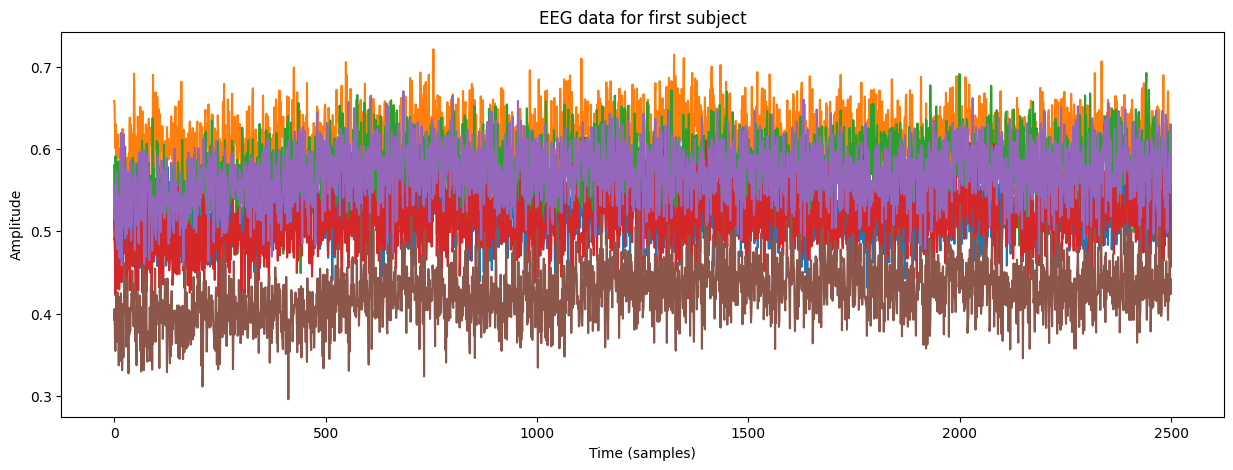

In [19]:
# Plot the data of the first subject
plt.figure(figsize=(15, 5))
plt.plot(y_pred[100,:,:])
plt.title("EEG data for first subject")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

## Perform FFT

C:\Users\orben\AppData\Local\Temp\ipykernel_31448\492354292.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  data_fft[i,:,j] = fft(data[i,:,j])


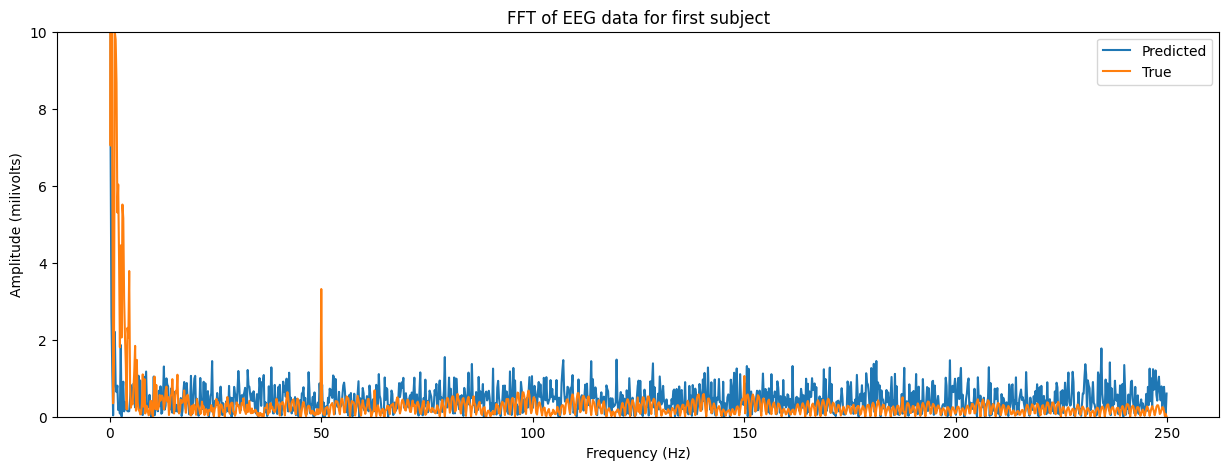

In [20]:
# preform fft on the prediction and the label
from scipy.fft import fft, fftfreq
def fft_transform(data):
    yf = np.zeros([data.shape[0], data.shape[1]//2, data.shape[2]])
    N = data.shape[1]
    T = 1.0 / SAMPLING_RATE
    xf = fftfreq(N, T)[:N//2]
    data_fft = np.zeros([data.shape[0], N, data.shape[2]])
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            data_fft[i,:,j] = fft(data[i,:,j])
            yf[i,:,j] = 2.0/N * np.abs(data_fft[i, :N//2, j])
    return xf, yf


# Perform FFT on the first subject's prediction and label
xf, yf_pred = fft_transform(y_pred)
xf, yf_true = fft_transform(y_true)
# Plot the FFT results
plt.figure(figsize=(15, 5))
plt.plot(xf, yf_pred[0,:,0], label='Predicted')
plt.plot(xf, yf_true[0,:,0], label='True')
plt.title("FFT of EEG data for first subject")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (milivolts)")
plt.ylim(0, 1e-2)  # Limit y-axis
plt.yticks(np.arange(0, 0.011, 0.002),np.arange(0, 11, 2))
plt.legend()
plt.show()

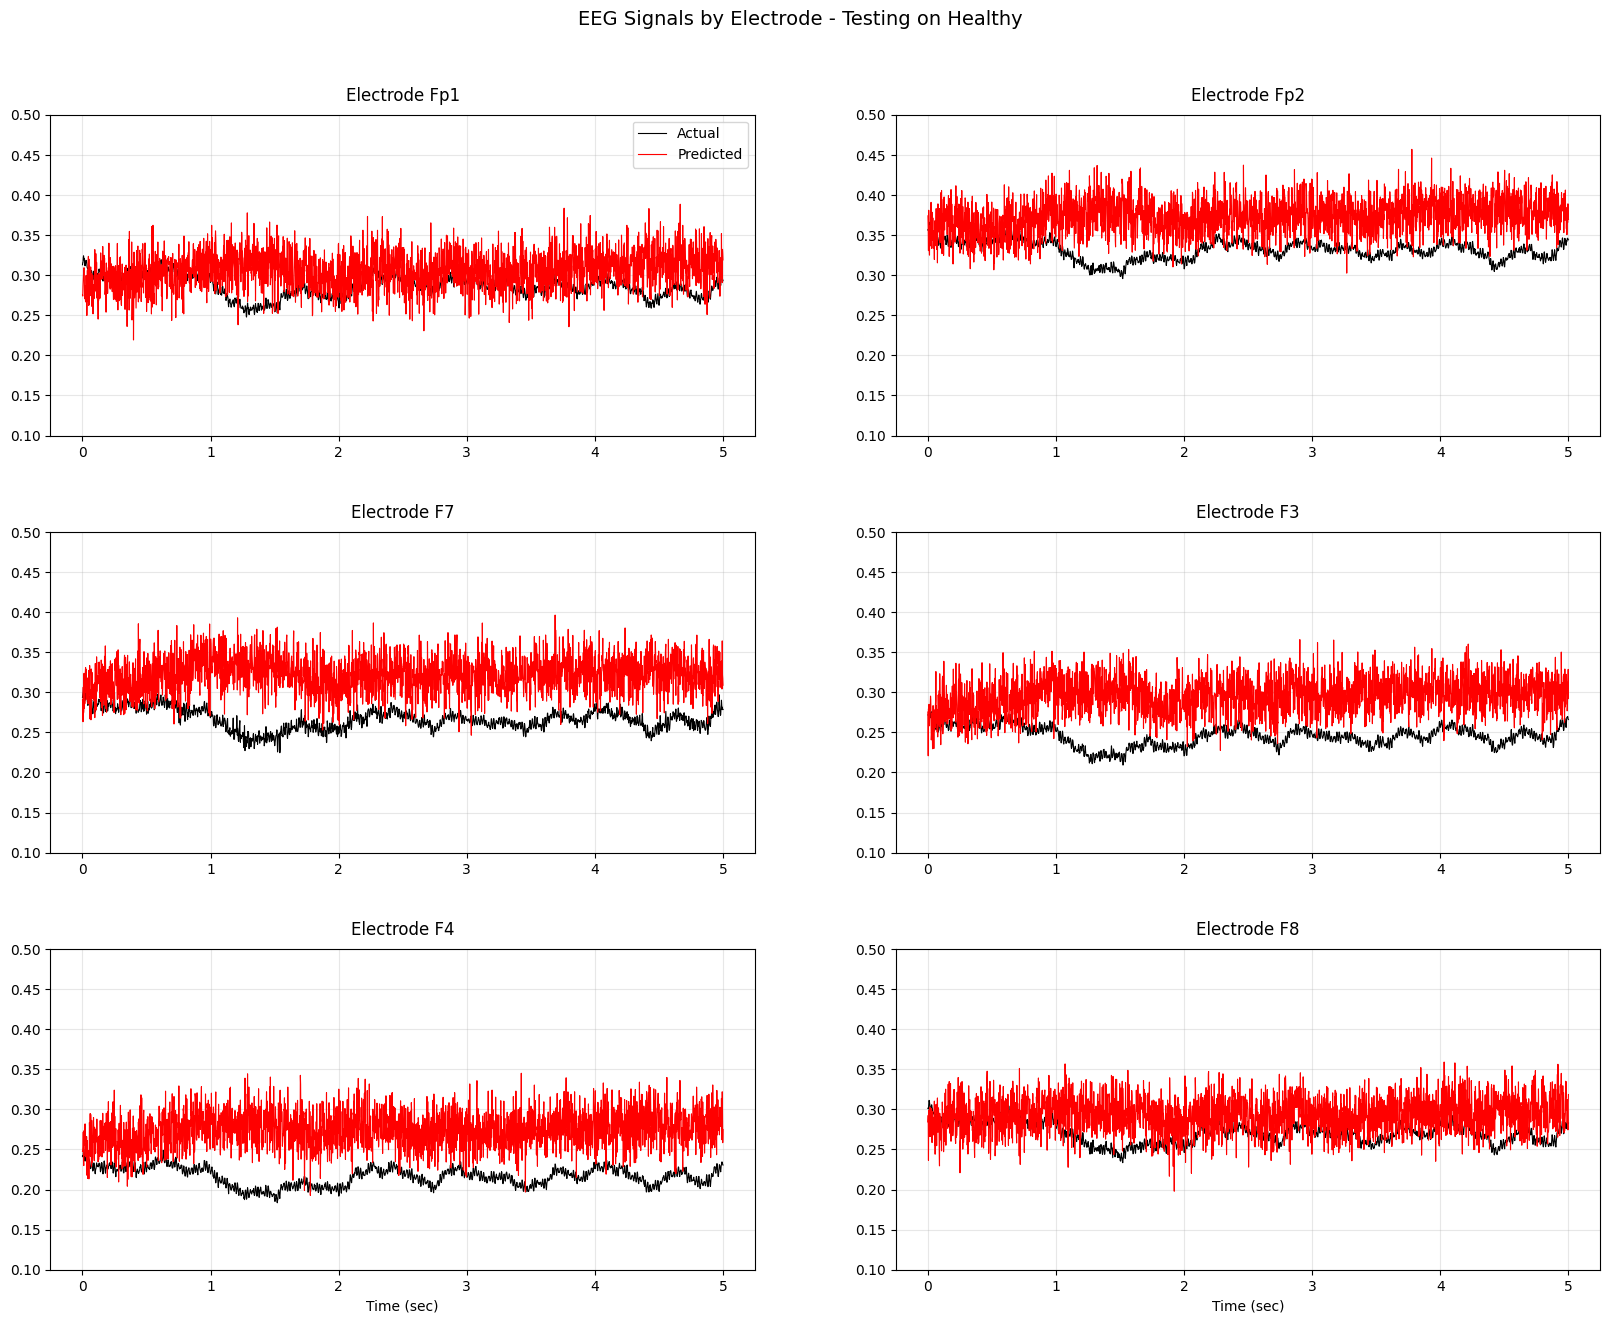

In [21]:
samples_to_show = int(5 * SAMPLING_RATE)
start_sample = 0
time_axis = np.linspace(0, 5, samples_to_show)

electrode_order = ['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8']

fig2, axes = plt.subplots(3, 2, figsize=(20, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for idx, electrode in enumerate(electrode_order):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    elec_idx = ELECTRODES.index(electrode)
    true_signal = y_true[20, start_sample:start_sample+samples_to_show, elec_idx]
    pred_signal = y_pred[20, start_sample:start_sample+samples_to_show, elec_idx]
    
    ax.plot(time_axis, true_signal, 'k-', label='Actual', linewidth=0.8)
    ax.plot(time_axis, pred_signal, 'r-', label='Predicted', linewidth=0.8)
    ax.set_ylim(0.1, 0.5)
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Electrode {electrode}', pad=10)
    ax.set_xticks(np.arange(0, 5.1, 1))
    if row == 2:
        ax.set_xlabel('Time (sec)')
    if idx == 0:
        ax.legend()

fig2.suptitle(f'EEG Signals by Electrode - Testing on {TEST_GROUP}', 
              y=0.95, fontsize=14)

plt.savefig(f'plots/EEG_Visualization_{TEST_GROUP}_recording20_5sec_grid.png', 
            dpi=300, bbox_inches='tight')
plt.show()

## Save to Actual & Predicted data as NPZ file

In [22]:
#save the y_pred and y_true, as well as the xf and yf_pred and yf_true to a file
np.savez(f'plots/fft_data_{TEST_GROUP}_Trained on_{TRAIN_GROUP}_frontal_electrodes(2).npz',
         y_pred=y_pred, y_true=y_true, xf=xf, yf_pred=yf_pred, yf_true=yf_true)

# Pearson & Permutations Test

In [23]:
def calculate_pearson_correlation(y_true, y_pred):
    """
    Compute the Pearson Correlation for each pair of rows and each electrode.
    """
    assert y_true.shape == y_pred.shape, "Shapes of y_true and y_pred must match"
    
    correlations = []
    
    # Iterate through each corresponding pair and electrode
    for i in range(y_true.shape[0]):  # For each sample
        sample_correlations = []
        for j in range(y_true.shape[2]):  # For each electrode
            corr, _ = pearsonr(y_true[i, :, j], y_pred[i, :, j])
            sample_correlations.append(corr)
        correlations.append(sample_correlations)
    
    correlations = np.array(correlations)
    # Average correlation across all pairs and electrodes
    average_corr = np.mean(correlations)
    
    return correlations, average_corr

def permutation_test_iterative(y_test, y_pred, n_permutations=1000):
    """
    Perform a permutation test to compute the null distribution of the metric.
    """
    null_distribution = []

    print("Running Permutation Test...")
    for _ in tqdm(range(n_permutations)):
        # Shuffle each row for each electrode independently
        shuffled_y_test = np.array([
            [np.random.permutation(row[:, i]) for i in range(row.shape[1])]
            for row in y_test
        ])
        shuffled_y_test = shuffled_y_test.transpose(0, 2, 1)  # Reshape to match original

        # Compute Pearson Correlation
        correlations, _ = calculate_pearson_correlation(shuffled_y_test, y_pred)

        # Aggregate the average correlation for this permutation
        null_distribution.append(np.mean(correlations))

    return np.array(null_distribution)



## Run The Test

In [24]:
# Calculate actual correlation
correlations, avg_corr = calculate_pearson_correlation(y_true, y_pred)

# Calculate average correlation per electrode
electrode_correlations = np.mean(correlations, axis=0)

print(f"\nResults for {TEST_GROUP} patients:")
print(f"Overall Average Correlation: {avg_corr:.4f}")
print("\nAverage Correlation by Electrode:")
for electrode, corr in zip(ELECTRODES, electrode_correlations):
    print(f"{electrode}: {corr:.4f}")

# Run permutation test
null_distribution = permutation_test_iterative(y_true, y_pred)

# Calculate p-value
p_value = np.mean(null_distribution >= avg_corr)
print(f"\nPermutation Test p-value: {p_value:.4f}")




Results for Healthy patients:
Overall Average Correlation: 0.0800

Average Correlation by Electrode:
Fp1: 0.0772
Fp2: 0.0779
F3: 0.0828
F4: 0.0855
F7: 0.0736
F8: 0.0830
Running Permutation Test...


100%|██████████| 1000/1000 [1:11:52<00:00,  4.31s/it]


Permutation Test p-value: 0.0000


## Plot the results

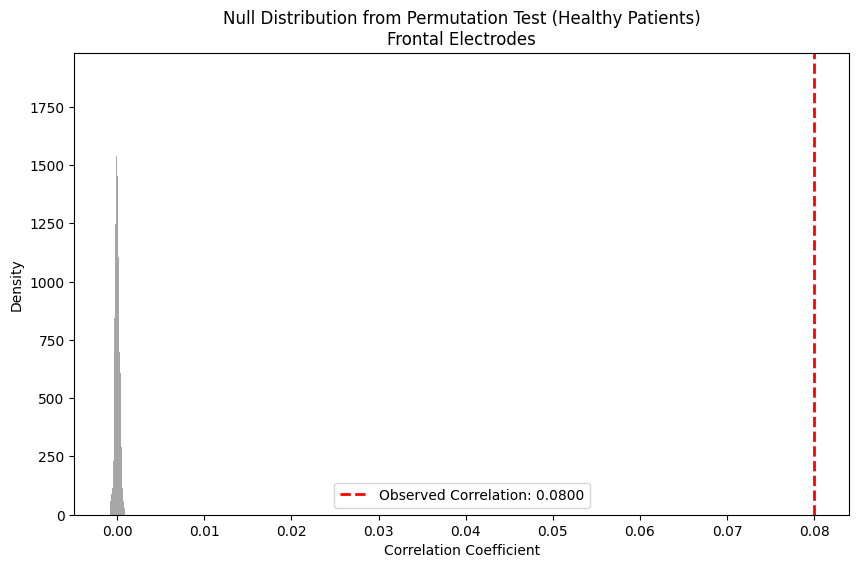

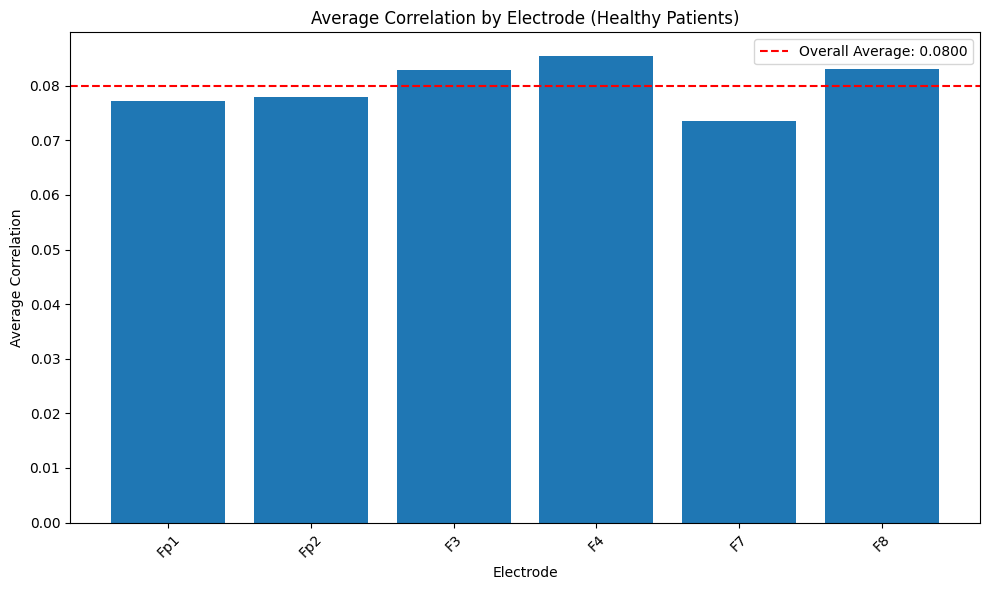


Results saved to plots/permutation_test_results_Healthy_frontal_electrodes.txt


In [25]:
# Plot null distribution
plt.figure(figsize=(10, 6))
plt.hist(null_distribution, bins=50, density=True, alpha=0.7, color='gray')
plt.axvline(avg_corr, color='red', linestyle='dashed', linewidth=2, label=f'Observed Correlation: {avg_corr:.4f}')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title(f'Null Distribution from Permutation Test ({TEST_GROUP} Patients)\nFrontal Electrodes')
plt.legend()
plt.show()

# Plot electrode-wise correlations
plt.figure(figsize=(10, 6))
plt.bar(ELECTRODES, electrode_correlations)
plt.axhline(y=avg_corr, color='r', linestyle='--', label=f'Overall Average: {avg_corr:.4f}')
plt.xlabel('Electrode')
plt.ylabel('Average Correlation')
plt.title(f'Average Correlation by Electrode ({TEST_GROUP} Patients)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Save results
results = {
    "Patient Group": TEST_GROUP,
    "Overall Average Correlation": avg_corr,
    "Permutation Test p-value": p_value,
    "Number of Test Samples": len(y_true),
    "Electrode-wise Correlations": {
        electrode: corr for electrode, corr in zip(ELECTRODES, electrode_correlations)
    }
}

# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

# Save results to file
results_path = f'plots/permutation_test_results_{TEST_GROUP}_frontal_electrodes.txt'
with open(results_path, 'w') as f:
    for key, value in results.items():
        if key == "Electrode-wise Correlations":
            f.write(f"\n{key}:\n")
            for electrode, corr in value.items():
                f.write(f"  {electrode}: {corr:.4f}\n")
        else:
            f.write(f"{key}: {value}\n")

print(f"\nResults saved to {results_path}")

# %%
